In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchsummary
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=28b151f37653fd7fd5524705df673779d4456d07261b2fe5ca25431f764cad11
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
dataset_path = '/kaggle/input/faces-processed/metadata.csv'
df = pd.read_csv(dataset_path)
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [4]:
df.shape

(95634, 5)

In [5]:
def classify_features(df):
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].nunique() < 10:
                categorical_features.append(column)
            else:
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else:
                continuous_features.append(column)

    return categorical_features, non_categorical_features, discrete_features, continuous_features

categorical, non_categorical, discrete, continuous = classify_features(df)

print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['label']
Non-Categorical Features: ['videoname', 'original']
Discrete Features: []
Continuous Features: ['original_width', 'original_height']


In [6]:
for i in categorical:
    print(i,':', df[i].unique())

for i in categorical:
    print(df[i].value_counts())

label : ['FAKE' 'REAL']
label
FAKE    79341
REAL    16293
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample

# Assuming 'df' is your DataFrame
# Separate real and fake entries
real_df = df[df['label'] == 'REAL']
fake_df = df[df['label'] == 'FAKE']

# Get the count of real entries
num_real = len(real_df)

# Under-sample the fake entries to match the count of real entries
fake_df_balanced = resample(fake_df, n_samples=num_real, random_state=42)

# Concatenate the balanced data
balanced_df = pd.concat([real_df, fake_df_balanced])

# Shuffle the dataset to mix real and fake entries
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the result
print(f"Balanced dataset:\n{balanced_df['label'].value_counts()}")

Balanced dataset:
label
REAL    16293
FAKE    16293
Name: count, dtype: int64


In [8]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

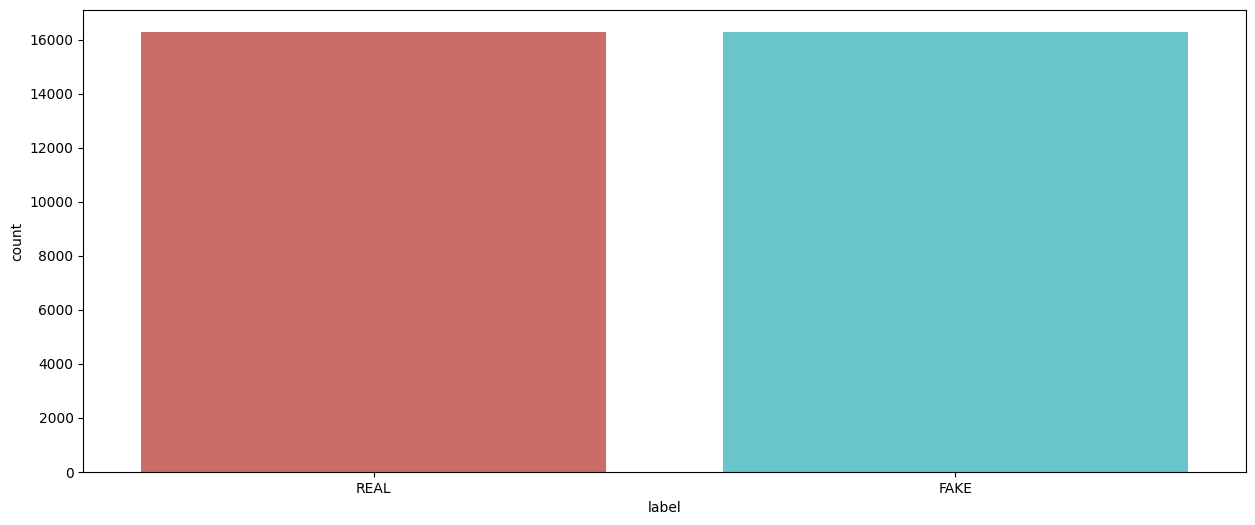

In [9]:
for i in categorical:
    plt.figure(figsize=(15,6))
    sns.countplot(x = balanced_df[i], data =balanced_df, palette = 'hls')
    plt.show()

In [10]:
real_df = balanced_df[balanced_df["label"] == "REAL"]
fake_df = balanced_df[balanced_df["label"] == "FAKE"]
sample_size = 10000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

Train_set, Test_set = train_test_split(sample_meta,test_size=0.25,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.25,random_state=42,stratify=Train_set['label'])

Train_set.shape,Val_set.shape,Test_set.shape

((11250, 5), (3750, 5), (5000, 5))

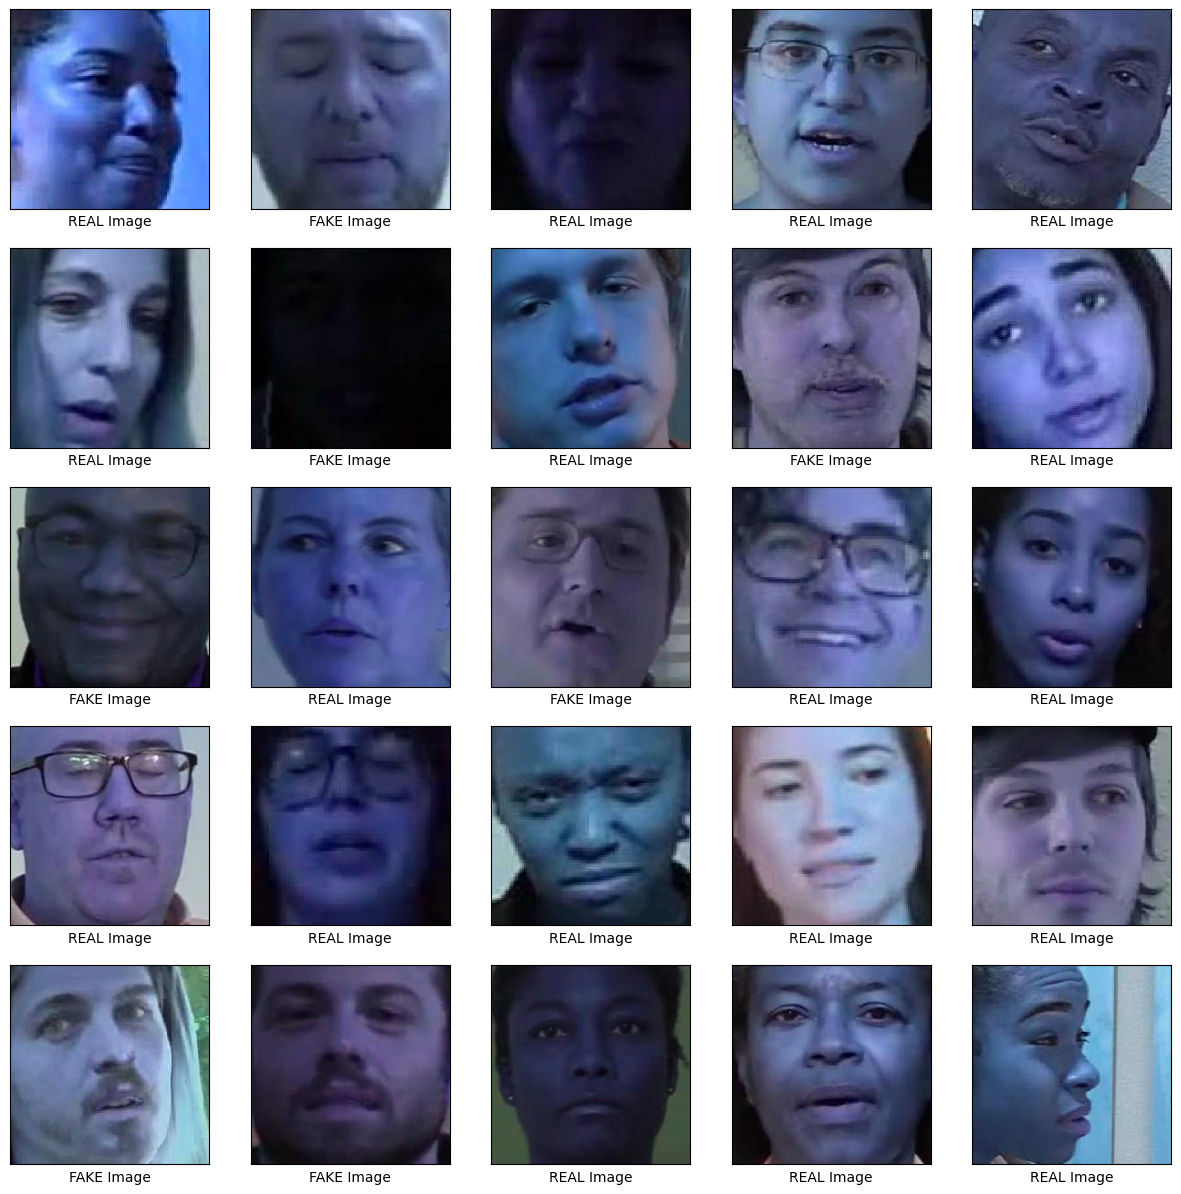

In [11]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('/kaggle/input/faces-processed/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

In [12]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('/kaggle/input/faces-processed/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)

X_train shape:  (11250, 224, 224, 3)
y_train shape:  (11250,)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms, models
import matplotlib.pyplot as plt

# Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
])

# Focal Loss for harder focus on challenging examples
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=3):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# Define TV Loss function
def tv_loss(x, weight=1e-5):
    batch_size, c, h, w = x.size()
    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :-1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :-1], 2).sum()
    return weight * (h_tv + w_tv) / (batch_size * c * h * w)

# CNN-RNN Model with Pre-trained ResNet and GRU
class CNNGRUModel(nn.Module):
    def __init__(self):
        super(CNNGRUModel, self).__init__()
        
        # Pre-trained ResNet Backbone
        resnet = models.resnet34(pretrained=True)
        self.resnet_base = nn.Sequential(*list(resnet.children())[:-2])
        self.dropout = nn.Dropout(0.5)

        # Calculate GRU input size based on ResNet output
        dummy_input = torch.zeros(1, 3, 224, 224)
        cnn_output = self.resnet_base(dummy_input)
        _, num_filters, height, width = cnn_output.shape
        self.gru_input_size = num_filters * width

        # GRU with layer normalization
        self.hidden_size = 128
        self.num_layers = 2
        self.gru = nn.GRU(input_size=self.gru_input_size, hidden_size=self.hidden_size, 
                          num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.LayerNorm(2 * self.hidden_size),
            nn.Dropout(0.3),
            nn.Linear(2 * self.hidden_size, 1)
        )

    def forward(self, x):
        x = self.resnet_base(x)
        x = self.dropout(x)
        
        batch_size, num_filters, height, width = x.shape
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, height, width * num_filters)

        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s] 


Epoch [1/35], Train Loss: 0.1260, Train Accuracy: 50.17%
Validation Loss: 0.0887, Validation Accuracy: 55.29%
Model saved at epoch 1 with validation loss 0.0887
Epoch [2/35], Train Loss: 0.0917, Train Accuracy: 54.03%
Validation Loss: 0.0845, Validation Accuracy: 57.24%
Model saved at epoch 2 with validation loss 0.0845
Epoch [3/35], Train Loss: 0.0883, Train Accuracy: 54.77%
Validation Loss: 0.0861, Validation Accuracy: 58.13%
Epoch [4/35], Train Loss: 0.0856, Train Accuracy: 58.39%
Validation Loss: 0.0821, Validation Accuracy: 63.02%
Model saved at epoch 4 with validation loss 0.0821
Epoch [5/35], Train Loss: 0.0820, Train Accuracy: 62.79%
Validation Loss: 0.0812, Validation Accuracy: 64.36%
Model saved at epoch 5 with validation loss 0.0812
Epoch [6/35], Train Loss: 0.0786, Train Accuracy: 67.04%
Validation Loss: 0.0826, Validation Accuracy: 64.93%
Epoch [7/35], Train Loss: 0.0741, Train Accuracy: 70.44%
Validation Loss: 0.0778, Validation Accuracy: 69.56%
Model saved at epoch 7 wit

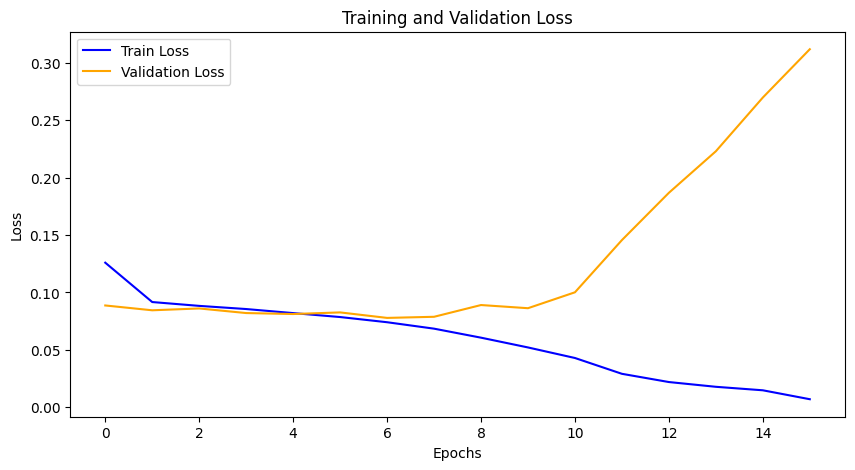

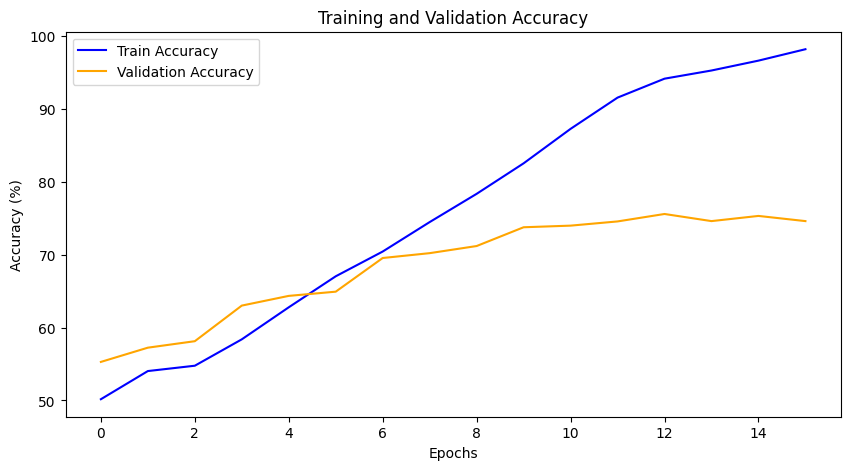

In [14]:
# Training and validation setup
X_train_tensor = (torch.tensor(X_train, dtype=torch.float32) / 255).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

train_size = int(0.8 * len(X_train_tensor))
val_size = len(X_train_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_tensor, y_train_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

cnn_gru_model = CNNGRUModel().cuda()
criterion = FocalLoss(alpha=1, gamma=3)
optimizer = optim.SGD(cnn_gru_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 35
patience = 9
best_val_loss = np.inf
patience_counter = 0
best_model_path = "/kaggle/working/best_cnn_gru_model.pth"

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    cnn_gru_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = cnn_gru_model(images)
        labels = labels.view(-1, 1)
        
        # Calculate loss
        focal_loss = criterion(outputs, labels)
        total_loss = focal_loss + tv_loss(images)  # Add TV Loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_gru_model.parameters(), max_norm=1.0)
        optimizer.step()

        predicted = (outputs >= 0).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += total_loss.item()
    
    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    cnn_gru_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = cnn_gru_model(images)
            labels = labels.view(-1, 1)
            
            focal_loss = criterion(outputs, labels)
            total_val_loss = focal_loss + tv_loss(images)  # Add TV Loss for validation
            val_loss += total_val_loss.item()

            predicted = (outputs >= 0).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    epoch_summary = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }
    
    # Print the epoch details
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%", flush=True)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%", flush=True)

    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(cnn_gru_model.state_dict(), best_model_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}", flush=True)
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}", flush=True)
        break

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

Evaluating on test data:
Accuracy: 0.75
Precision: 0.73
Recall: 0.79
F1 Score: 0.76


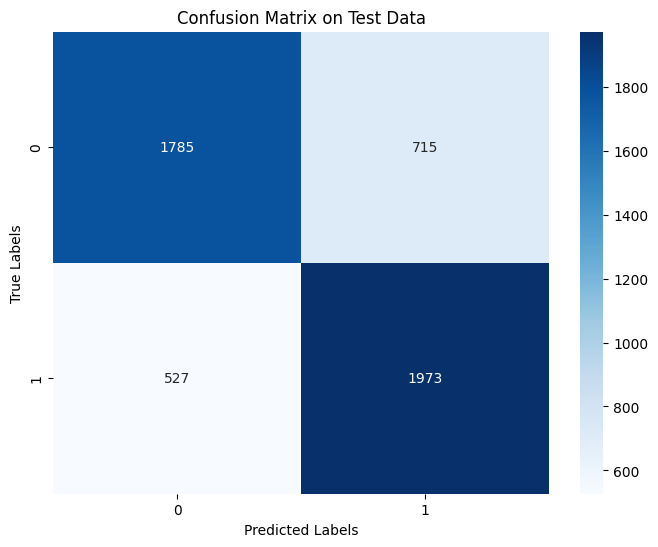


Layer Type Counts:
CNNGRUModel: 1 times
Conv2d: 36 times
BatchNorm2d: 36 times
ReLU: 17 times
MaxPool2d: 1 times
BasicBlock: 16 times
Dropout: 2 times
GRU: 1 times
LayerNorm: 1 times
Linear: 1 times


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert test data to PyTorch tensors
X_test_tensor = (torch.tensor(X_test, dtype=torch.float32) / 255).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Switch to evaluation mode
cnn_gru_model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        
        # Get model outputs and apply sigmoid to get probabilities
        outputs = torch.sigmoid(cnn_gru_model(images))
        
        # Convert probabilities to binary predictions with threshold 0.5
        preds = (outputs >= 0.5).float()
        
        # Append predictions and labels to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metrics calculation
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print the evaluation metrics
print("Evaluating on test data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Test Data")
plt.show()

import torch
import torch.nn as nn
from torchsummary import summary
from collections import Counter

# Define your model (assuming CNNGRUModel is already defined)
cnn_gru_model = CNNGRUModel().cuda()

# Step 1: Display the standard summary of the model structure with input shape
# print("Model Summary:\n")
# summary(cnn_gru_model, input_size=(3, 224, 224))

# Step 2: Count occurrences of each unique layer type
def count_layer_types(model):
    layer_counts = Counter()
    for layer in model.modules():
        layer_name = type(layer).__name__
        if layer_name != "Sequential":  # Ignore Sequential containers themselves
            layer_counts[layer_name] += 1
    return layer_counts

# Get layer counts
layer_counts = count_layer_types(cnn_gru_model)

# Step 3: Print the unique layer types and counts
print("\nLayer Type Counts:")
for layer_type, count in layer_counts.items():
    print(f"{layer_type}: {count} times")

In [18]:
#Model Summary without printing all pre trained layers
import torch
import torch.nn as nn
from torchvision import models

class CNNGRUModel(nn.Module):
    def __init__(self):
        super(CNNGRUModel, self).__init__()
        
        # Pre-trained ResNet Backbone
        resnet = models.resnet34(pretrained=True)
        self.resnet_base = nn.Sequential(*list(resnet.children())[:-2])  # Use up to last conv layer
        self.dropout = nn.Dropout(0.5)

        # Calculate GRU input size based on ResNet output
        dummy_input = torch.zeros(1, 3, 224, 224)
        cnn_output = self.resnet_base(dummy_input)
        _, num_filters, height, width = cnn_output.shape
        self.gru_input_size = num_filters * width

        # GRU with layer normalization
        self.hidden_size = 128
        self.num_layers = 2
        self.gru = nn.GRU(input_size=self.gru_input_size, hidden_size=self.hidden_size, 
                          num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.LayerNorm(2 * self.hidden_size),
            nn.Dropout(0.3),
            nn.Linear(2 * self.hidden_size, 1)
        )

    def forward(self, x):
        # Full forward pass
        x = self.resnet_base(x)
        x = self.dropout(x)
        
        # Reshape output to fit into GRU
        batch_size, num_filters, height, width = x.shape
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, height, width * num_filters)

        # GRU forward pass
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]  # Take the output from the last time step
        out = self.fc(out)
        return out

# Instantiate the model
model = CNNGRUModel().cuda()

# Custom summary function for full model with pretrained and custom layers
def custom_full_summary(model):
    print("Full Model Summary:\n")
    print(f"{'Layer':<30} {'Output Shape':<30} {'Param #':<10}")
    print("="*80)

    total_params = 0
    
    # ResNet Backbone summary
    resnet_params = sum(p.numel() for p in model.resnet_base.parameters() if p.requires_grad)
    total_params += resnet_params
    resnet_output_shape = (1, 512, 7, 7)  # Expected output from ResNet layer
    print(f"{'ResNet Backbone':<30} {str(resnet_output_shape):<30} {resnet_params:<10}")

    # GRU Layer summary
    gru_input_shape = (1, 7, model.gru_input_size)  # Simulated input shape for GRU layer
    gru_output_shape = (gru_input_shape[0], gru_input_shape[1], 2 * model.hidden_size)
    gru_params = sum(p.numel() for p in model.gru.parameters() if p.requires_grad)
    total_params += gru_params
    print(f"{'GRU Layer':<30} {str(gru_output_shape):<30} {gru_params:<10}")

    # Fully Connected Layer summary
    fc_input_shape = (gru_output_shape[0], gru_output_shape[2])
    fc_output_shape = (fc_input_shape[0], 1)
    fc_params = sum(p.numel() for p in model.fc.parameters() if p.requires_grad)
    total_params += fc_params
    print(f"{'Fully Connected Layer':<30} {str(fc_output_shape):<30} {fc_params:<10}")

    print("="*80)
    print(f"Total Trainable Parameters: {total_params}")

# Call the custom summary
custom_full_summary(model)

Full Model Summary:

Layer                          Output Shape                   Param #   
ResNet Backbone                (1, 512, 7, 7)                 21284672  
GRU Layer                      (1, 7, 256)                    3148800   
Fully Connected Layer          (1, 1)                         769       
Total Trainable Parameters: 24434241


In [19]:
print("Model Summary:\n")
summary(cnn_gru_model, input_size=(3, 224, 224))

Model Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14   